In [ ]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

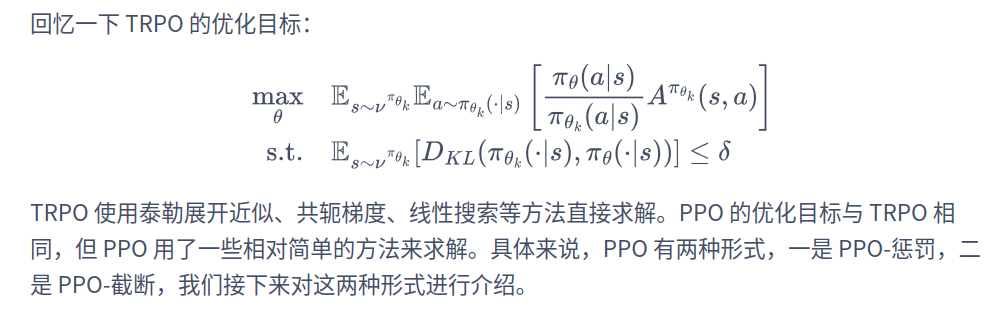  
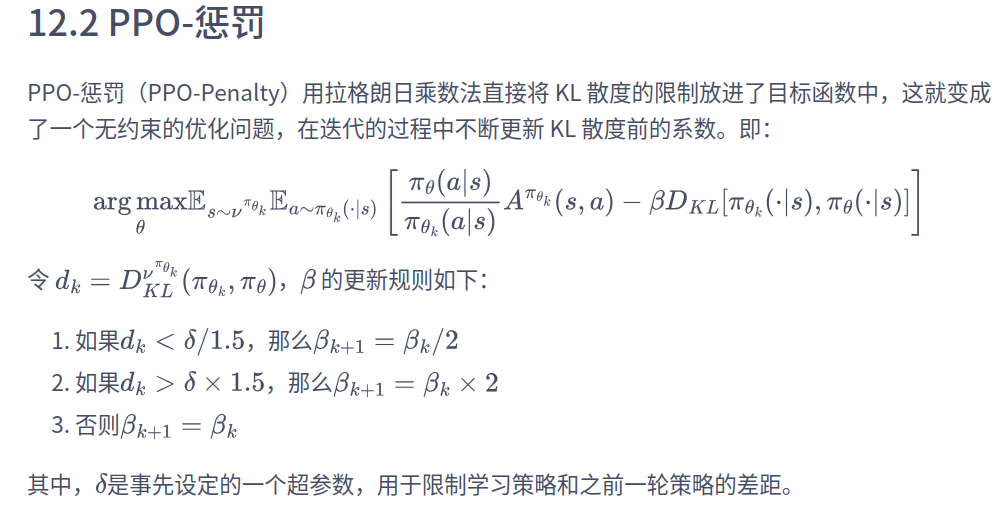  
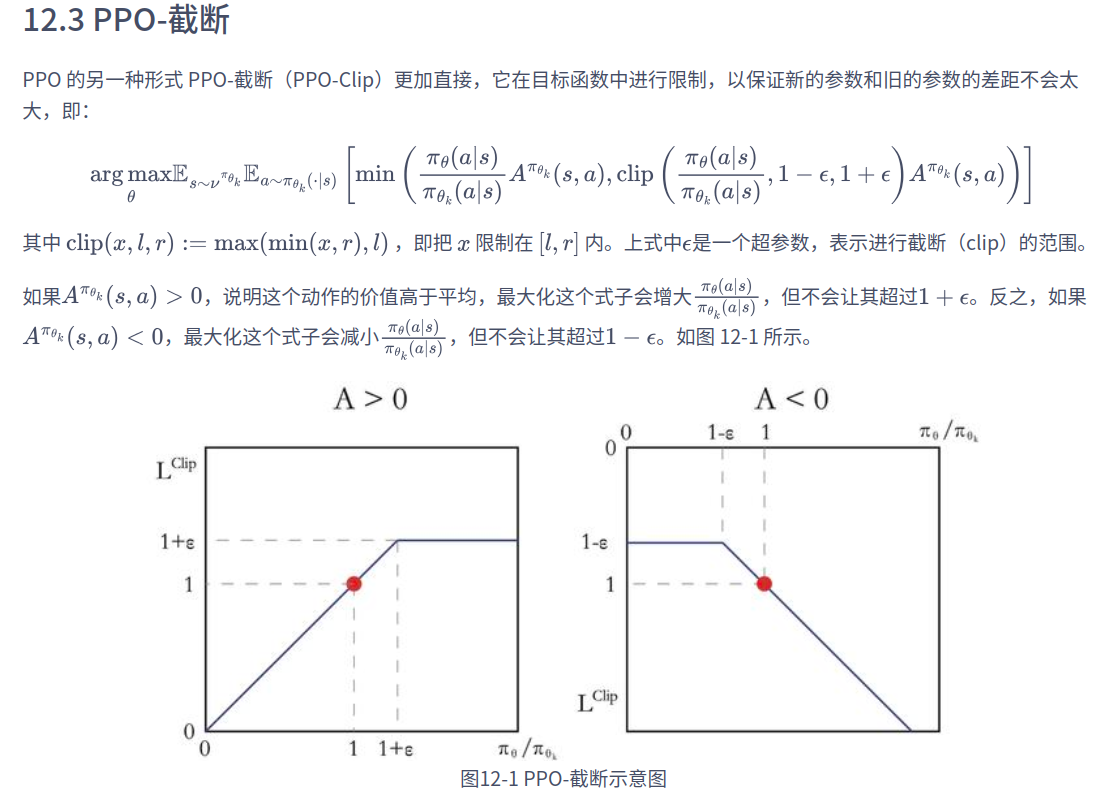

In [9]:
class Base_PPO:
    """ PPO算法基类,后面需重写部分方法和成员
    以区别实现离散和连续动作空间 """
    def __init__(self,lmbda, epochs, eps, gamma, device):
        """ 基类需要定义自己的actor,critic,以及对应的critic_optim """
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def get_actor_distribution(self,actor,states,detach=False):
        """ 需要针对离散和连续进行重写
        离散分布输出每个离散量的概率
        连续分布输出每个维度上的动作值的正态分布 """
        if(detach):
            return torch.distributions.Categorical(actor(states).detach())
        return torch.distributions.Categorical(actor(states))
    
    def take_action(self, state):
        """ 需要重写返回list还是标量 """
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action_dist = self.get_actor_distribution(self.actor,state)
        action = action_dist.sample()
        return action.item()
        # 返回一个标量,动作的索引

    def update(self, transition_dict):
        # (episode_num_step,state_dim)
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        # (episode_num_step,1)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        # q_value       
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)
        # A
        td_delta = td_target - self.critic(states)

        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        # 在每一步的状态下根据策略网络输出的概率生成动作的概率分布，这里计算的旧分布需要作为常量，detach
        old_action_dists =self.get_actor_distribution(self.actor,states,detach=True)

        # 对输出的动作的概率计算log，使用策略网络计算得到，detach之后变成了常量，只计算实际采取的那个动作的概率
        old_log_probs = old_action_dists.log_prob(actions)

        for _ in range(self.epochs):
            log_probs=self.get_actor_distribution(self.actor,states).log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            # 目标函数
            surr1 = ratio * advantage
            # 截断后的目标函数
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数

            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [10]:
# 离散的PPO
class PPO(Base_PPO):
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        super().__init__(lmbda, epochs, eps, gamma, device)
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)


In [11]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


/home/zhangjinrui/anaconda3/envs/pytorch/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 50/50 [00:06<00:00,  7.69it/s, episode=500, return=185.800]


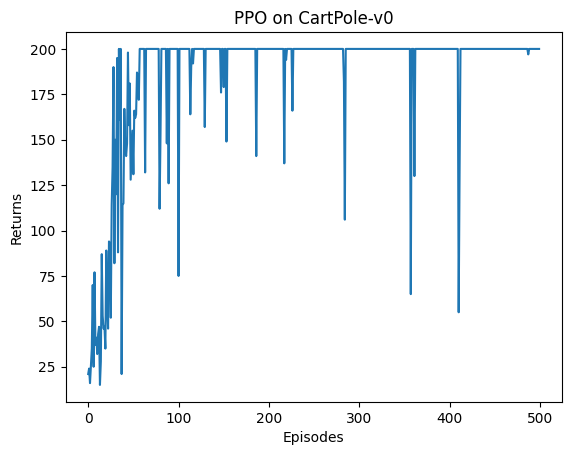

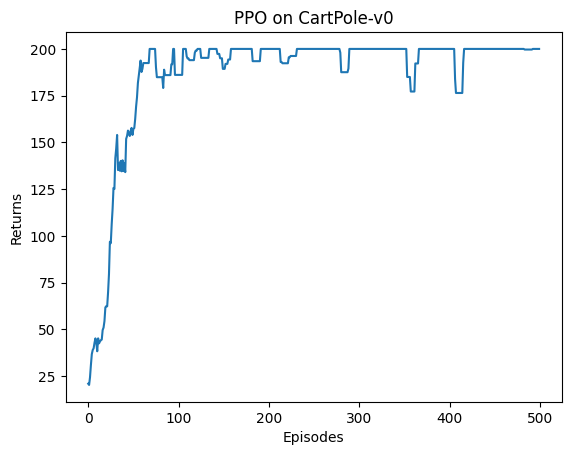

In [4]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [12]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

In [ ]:
# 连续的PPO
class PPOContinuous(Base_PPO):
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        super().__init__(lmbda, epochs, eps, gamma, device)
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        
    def get_actor_distribution(self,actor,states,detach=False):
        mu, std = actor(states)
        if(detach):
            return torch.distributions.Normal(mu.detach(), std.detach())
        else: 
            return torch.distributions.Normal(mu, std)
        
    def take_action(self, state):
        """ 需要重写返回list还是标量 """
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action_dist = self.get_actor_distribution(self.actor,state)
        action = action_dist.sample()
        return [action.item()]
        # 返回一个列表,不同维度上的动作的输出值

    def update(self, transition_dict):
        # (episode_num_step,state_dim)
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        # (episode_num_step,1)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)


        # ——————————————————————
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        # ——————————————————————


        # q_value       
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -dones)
        # A
        td_delta = td_target - self.critic(states)

        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        # 在每一步的状态下根据策略网络输出的概率生成动作的概率分布，这里计算的旧分布需要作为常量，detach
        old_action_dists =self.get_actor_distribution(self.actor,states,detach=True)

        # 对输出的动作的概率计算log，使用策略网络计算得到，detach之后变成了常量，只计算实际采取的那个动作的概率
        old_log_probs = old_action_dists.log_prob(actions)

        for _ in range(self.epochs):
            log_probs=self.get_actor_distribution(self.actor,states).log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            # 目标函数
            surr1 = ratio * advantage
            # 截断后的目标函数
            surr2 = torch.clamp(ratio, 1 - self.eps,1 + self.eps) * advantage  # 截断
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数

            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [14]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration 9: 100%|██████████| 200/200 [00:26<00:00,  7.54it/s, episode=2000, return=-570.659]


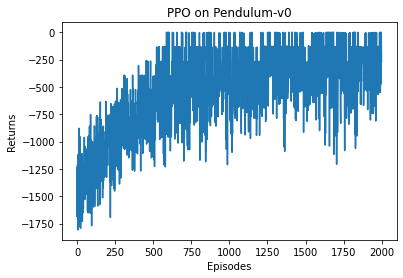

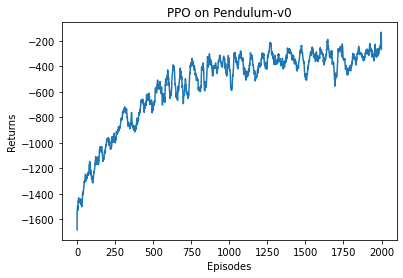

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()